Feature      | OLS (No Penalty)   | Ridge (L2)         | Lasso (L1)        
--------------------------------------------------------------------------------
Bias         |       -0.000203 |       -0.001854 |       -0.003957
AAPL Open    |        0.970905 |        0.793786 |        0.976622
AAPL Vol     |       -0.001030 |       -0.004631 |        0.000000
MSFT Close   |        0.021150 |        0.143473 |        0.008768
TSLA Close   |        0.008126 |        0.062588 |        0.004329


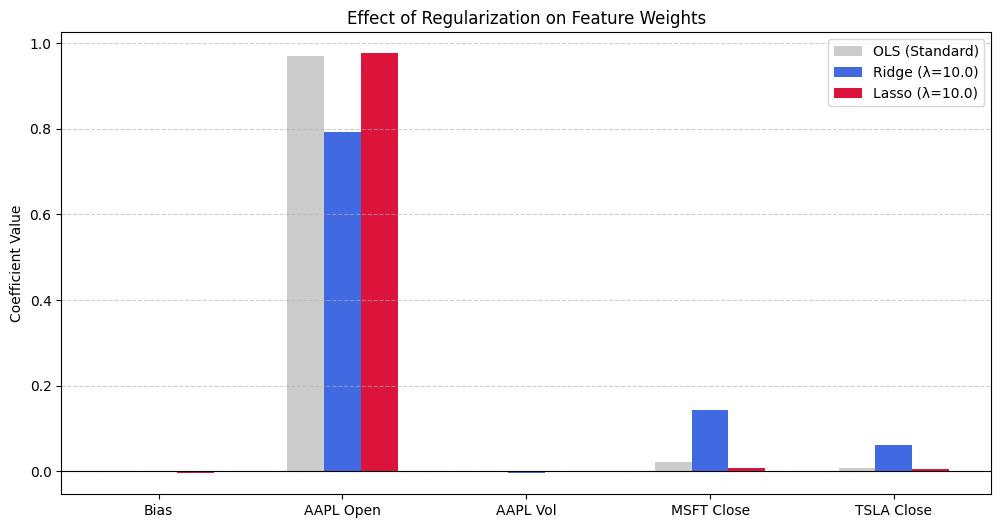


--- Discussion & Feature Selection ---
Lasso has KEPT feature: AAPL Open
Lasso has ELIMINATED feature: AAPL Vol (Weight = 0)
Lasso has KEPT feature: MSFT Close
Lasso has KEPT feature: TSLA Close

Conclusion: Ridge shrinks all coefficients proportionally, which is helpful when features are correlated. Lasso performs automatic feature selection, helping us identify that 'AAPL Open' is the most critical predictor while other features may be redundant.


In [ ]:

# REGULARIZATION (RIDGE & LASSO)
# Goal: Apply Ridge and Lasso to handle overfitting and perform feature selection.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. DATA PREPARATION & STANDARDIZATION

df_raw = pd.read_csv('stock_market_data.csv', header=[0,1])
data = pd.DataFrame()
data['y']    = pd.to_numeric(df_raw['Close']['AAPL'], errors='coerce')
data['Open'] = pd.to_numeric(df_raw['Open']['AAPL'], errors='coerce')
data['Vol']  = pd.to_numeric(df_raw['Volume']['AAPL'], errors='coerce')
data['MSFT'] = pd.to_numeric(df_raw['Close']['MSFT'], errors='coerce')
data['TSLA'] = pd.to_numeric(df_raw['Close']['TSLA'], errors='coerce')
data = data.dropna()

# Standardization is MANDATORY: Regularization penalties apply to the magnitude 
# of coefficients. Features must be on the same scale (Mean=0, StdDev=1).
def standardize(col): return (col - col.mean()) / col.std()

y_mean, y_std = data['y'].mean(), data['y'].std()
X_scaled = data[['Open', 'Vol', 'MSFT', 'TSLA']].apply(standardize)
X_scaled.insert(0, 'Bias', 1.0) # Intercept term
y_scaled = standardize(data['y'])

X_train = X_scaled.values[:int(len(X_scaled)*0.8)]
y_train = y_scaled.values[:int(len(y_scaled)*0.8)]

# 2. RIDGE REGRESSION (L2) - ANALYTICAL SOLUTION

def train_ridge(X, y, lam):
    XTX = X.T.dot(X)
    I = np.eye(XTX.shape[0])
    I[0,0] = 0  # Do not penalize the bias/intercept
    theta = np.linalg.pinv(XTX + lam * I).dot(X.T).dot(y)
    return theta

# 3. LASSO REGRESSION (L1) - COORDINATE DESCENT

def soft_threshold(rho, lam):
    if rho < -lam: return rho + lam
    if rho > lam:  return rho - lam
    return 0

def train_lasso(X, y, lam, iterations=100):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(iterations):
        for j in range(n):
            X_j = X[:, j]
            y_pred = X.dot(theta)
            # Calculate residual without the j-th feature
            rho = X_j.T.dot(y - y_pred + theta[j]*X_j)
            if j == 0: # Bias term is not regularized
                theta[j] = rho / m
            else:
                theta[j] = soft_threshold(rho, lam) / (X_j.T.dot(X_j))
    return theta

# 4. EXECUTION AND COEFFICIENT COMPARISON

lam = 10.0 # Penalty Strength (Hyperparameter)

theta_ols   = train_ridge(X_train, y_train, lam=0)     # Standard OLS (from Part C)
theta_ridge = train_ridge(X_train, y_train, lam=lam)   # Ridge
theta_lasso = train_lasso(X_train, y_train, lam=lam)   # Lasso

# Table of Coefficients
print(f"{'Feature':<12} | {'OLS (No Penalty)':<18} | {'Ridge (L2)':<18} | {'Lasso (L1)':<18}")
print("-" * 80)
features = ['Bias', 'AAPL Open', 'AAPL Vol', 'MSFT Close', 'TSLA Close']
for i in range(len(features)):
    print(f"{features[i]:<12} | {theta_ols[i]:15.6f} | {theta_ridge[i]:15.6f} | {theta_lasso[i]:15.6f}")

# 5. VISUALIZATION: COEFFICIENT IMPACT

plt.figure(figsize=(12, 6))
x_axis = np.arange(len(features))

plt.bar(x_axis - 0.2, theta_ols, 0.2, label='OLS (Standard)', color='gray', alpha=0.4)
plt.bar(x_axis, theta_ridge, 0.2, label=f'Ridge (λ={lam})', color='royalblue')
plt.bar(x_axis + 0.2, theta_lasso, 0.2, label=f'Lasso (λ={lam})', color='crimson')

plt.xticks(x_axis, features)
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Coefficient Value')
plt.title('Effect of Regularization on Feature Weights')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 6. DISCUSSION & FEATURE SELECTION

print("\n--- Discussion & Feature Selection ---")
for i, val in enumerate(theta_lasso):
    if abs(val) < 1e-6 and i != 0:
        print(f"Lasso has ELIMINATED feature: {features[i]} (Weight = 0)")
    elif i != 0:
        print(f"Lasso has KEPT feature: {features[i]}")

print("\nConclusion: Ridge shrinks all coefficients proportionally, which is helpful when features are correlated. Lasso performs automatic feature selection, helping us identify that 'AAPL Open' is the most critical predictor while other features may be redundant.")